#### Imports

In [1]:
%%capture

!pip install category_encoders==2.*
!pip install pandas_profiling==2.*

In [4]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, validation_curve # k-fold CV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # Hyperparameter tuning
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

####Data Wrangling

In [5]:
def wrangle(me):
  df=pd.read_csv(me, index_col='id').sort_index()
  df.drop(['Unnamed: 0'], axis=1, inplace=True)

  # drop columns with NaN values (>50%)
  df.dropna(axis=1, thresh=2431, inplace = True)

  # create a new feature for mean of systolic and then drop sys1, sys2, sys3
  df['systolic_bp'] = (df['systol1'] + df['systol2'] + df['systol3'])/3
  df.drop(columns= ['systol1','systol2','systol3'], inplace=True)
  # create new feature for mean of diastolic and then drop dias1, dias2, dias3
  df['diastolic_bp'] = (df['diastol1']+df['diastol2']+df['diastol3'])/3
  df.drop(columns= ['diastol1','diastol2','diastol3'], inplace=True)

  # create target vector (anemia), and drop 'hemoglobin'
  # df.loc[(df['hemoglobin'] <12), 'anemia'] = 1
  # df.loc[(df['hemoglobin'] >=12), 'anemia'] = 0
  # df.drop(columns= ['hemoglobin'], inplace=True)
  # change dtype:
  # df[['anemia']] = df['anemia'].astype(int)
  # df[['education']] = df['education'].astype(int)
  # df[['dominant_hand']] = df['dominant_hand'].astype(int)
  # drop any row with a missing value
  df.dropna(axis=0, how='any', inplace=True)

  # sort column by their names
  df = df.reindex(sorted(df.columns), axis=1)

  return df

df = wrangle('/content/both_gender.csv')


Define Target Variable and Features

In [6]:
target = 'dominant_hand'
y = df[target]
X = df.drop(columns=target)
X.shape, y.shape

((985, 39), (985,))

####Train_Test_Validation Split

In [7]:

X_train_, X_test, y_train_, y_test = train_test_split(X, y , test_size=0.2)

from imblearn.over_sampling import SMOTE
from collections import Counter


smote = SMOTE()

# fit predictor and target variable
X_smote, y_smote = smote.fit_resample(X_train_, y_train_)

X_train, X_val, y_train, y_val = train_test_split(X_smote, y_smote, test_size=0.25)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({1.0: 893, 2.0: 72, 3.0: 20})
Resample dataset shape Counter({1.0: 715, 2.0: 715, 3.0: 715})


####Baseline accuracy score

In [8]:
print('baseline accuracy:', y_train.value_counts(normalize=True).max())

baseline accuracy: 0.3345771144278607


####Build the model

In [9]:
model_randomf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

model_randomf.fit(X_train, y_train);

print('FOREST: Training Accuracy:',model_randomf.score(X_train, y_train))

print('FOREST: Test Accuracy:',model_randomf.score(X_test, y_test))

FOREST: Training Accuracy: 1.0
FOREST: Test Accuracy: 0.8730964467005076


#### Important features 

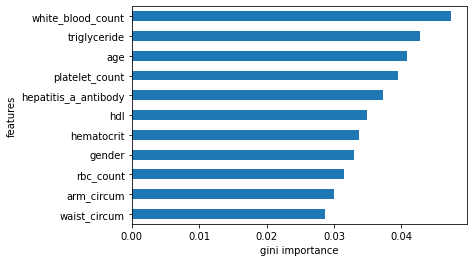

In [18]:
features = model_randomf.named_steps['ordinalencoder'].get_feature_names()
gini = model_randomf.named_steps['randomforestclassifier'].feature_importances_
pd.Series(data=gini, index=features).sort_values(key=abs).tail(11).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('gini importance');

####predicitons

In [ ]:
predictions = pd.DataFrame(data=model_randomf.predict(X_test), index=X_test.index)
predictions

In [20]:
predictions.value_counts()

1.0    189
2.0      8
dtype: int64